# **스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from keras.regularizers import l1
import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
def dl_acc_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['accuracy'], label='Train_Accuracy', marker = '.')
    plt.plot(history['val_accuracy'], label='Val_Accuracy', marker = '.')

    plt.ylabel('Acc')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [6]:
data_train = pd.read_csv('../2024.10.16_미니프로젝트 3차_실습자료\data01_train.csv')
data_test = pd.read_csv('../2024.10.16_미니프로젝트 3차_실습자료\data01_test.csv')
data_is_dy_train = joblib.load('../2024.10.16_미니프로젝트 3차_실습자료\Is_Dynamic_DF.pkl')
feature = pd.read_csv('../2024.10.16_미니프로젝트 3차_실습자료/features.csv')
data_test.drop(columns='subject',inplace=True)
data_train.drop(columns='subject',inplace=True)
data_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


# PCA를 통한 데이터 경량화

In [7]:
x = data_train.drop(columns='Activity')
x_columns = x.columns

In [8]:
x

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.032207,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.246705,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.388765,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,0.050888,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.013902,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,0.052914,-0.305772,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,0.325461,-0.622617,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,0.362439,-0.597610,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,0.031915,0.196921,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920


In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 정규화
scaler = StandardScaler()
x = scaler.fit_transform(x)
x = pd.DataFrame(x,columns=x_columns)

# PCA Decomposition
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(x)
principalDF = pd.DataFrame(data=principalComponents,columns=['Comp1','Comp2','Comp3','Comp4','Comp5','Comp6','Comp7','Comp8','Comp9','Comp10','Comp11','Comp12','Comp13','Comp14','Comp15','Comp16','Comp17','Comp18','Comp19','Comp20'])
display(principalDF)
display(principalDF.corr())


,Comp1,Comp2,Comp3,Comp4,Comp5,Comp6,Comp7,Comp8,Comp9,Comp10,Comp11,Comp12,Comp13,Comp14,Comp15,Comp16,Comp17,Comp18,Comp19,Comp20
0,-13.457865,-1.018722,-1.473502,-3.173522,-3.552740,1.630544,-0.888701,0.713501,-0.270988,0.813511,-0.021769,1.540031,-1.915225,-0.722601,0.087224,1.801308,-0.700502,-0.810181,-0.112014,-0.595766
1,-15.708905,5.066815,0.556654,1.849810,3.893717,0.086818,-1.068139,1.563345,-2.994460,1.016738,-1.870366,3.125093,0.417878,-1.651049,-0.324364,1.136956,0.561593,0.051177,1.144562,0.589228
2,-15.439979,9.205352,-5.061634,-2.351507,0.204771,-2.022815,2.227008,-0.607504,-3.044941,-0.123431,-0.317540,-0.744291,1.405598,1.239665,0.472004,0.394798,-0.978776,-1.820907,0.728341,0.479334
3,14.589192,-1.414871,-5.251271,-0.649552,1.798735,2.422224,-0.882786,0.045963,2.826131,2.016632,2.075050,-0.667751,0.945008,2.055222,-1.899713,-0.506332,-1.566108,-2.561922,-1.828632,0.286699
4,13.079971,-8.621200,-1.769857,4.143246,-4.135092,-1.148985,2.765234,4.072062,-2.504126,0.714006,-3.970046,-1.836319,-0.099330,3.250702,1.025094,4.143225,3.571120,0.474742,-1.844412,1.960869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,-14.029339,-2.962421,0.767613,-2.585596,-4.698077,-0.589992,-1.261229,-1.341549,0.559137,-0.279070,-0.337077,0.086473,-1.176244,-1.578888,-0.064987,0.711889,-0.154856,0.102968,0.837851,1.109035
5877,10.209958,-5.131859,-2.487399,1.193794,0.508915,-3.673750,-3.043886,-0.532648,-1.297943,-2.938277,-3.013973,0.311578,-3.128471,-1.949429,0.765084,-5.108032,0.814883,1.024060,-1.720259,-0.759530
5878,-16.369323,9.625145,0.019104,2.271312,5.652903,-0.884971,2.720300,1.120433,-1.876030,-0.093254,1.219781,-1.615842,1.819197,1.221794,-2.148702,1.769499,-1.396720,-0.478122,-0.597285,-1.559279
5879,12.704514,-6.886616,-4.183502,3.252779,-1.379177,1.811236,-1.093410,0.989941,-2.129997,-2.766114,2.900785,-2.489773,-0.836149,3.013828,0.882053,-1.705256,-0.997997,1.525835,-1.502212,1.972100


,Comp1,Comp2,Comp3,Comp4,Comp5,Comp6,Comp7,Comp8,Comp9,Comp10,Comp11,Comp12,Comp13,Comp14,Comp15,Comp16,Comp17,Comp18,Comp19,Comp20
Comp1,1.000000e+00,2.549861e-16,4.709079e-17,5.862998e-17,-1.963969e-16,2.468768e-16,-3.959302e-16,3.068400e-16,5.910128e-17,4.214647e-16,-3.125176e-17,-1.183052e-16,1.820389e-16,-7.414119e-17,-1.793035e-16,5.287665e-16,-5.407653e-16,4.364775e-17,-5.854016e-16,8.131573e-17
Comp2,2.549861e-16,1.000000e+00,-6.638944e-17,1.485924e-16,2.017316e-16,5.611384e-17,-3.659078e-18,8.614065e-16,-2.578455e-15,-1.138922e-15,6.468433e-15,3.029815e-16,3.400585e-15,3.407761e-17,3.735310e-16,-3.310786e-15,1.516175e-15,-1.892402e-15,3.151535e-15,2.095672e-16
Comp3,4.709079e-17,-6.638944e-17,1.000000e+00,-1.134034e-16,1.018698e-16,1.545339e-16,-2.943941e-17,2.840578e-16,-9.793879e-17,1.469223e-17,2.802651e-16,1.479395e-16,1.433869e-16,1.747333e-16,1.038114e-16,8.111729e-18,-8.713616e-17,1.150886e-16,-4.673173e-17,7.614417e-17
Comp4,5.862998e-17,1.485924e-16,-1.134034e-16,1.000000e+00,-1.820401e-16,1.229649e-16,-4.349915e-16,3.035574e-16,-4.295442e-17,1.495665e-16,2.628754e-17,2.960989e-17,1.059328e-16,-3.123623e-17,-6.629387e-17,6.433678e-17,1.037725e-17,-1.505755e-16,-5.028614e-17,-1.119343e-16
Comp5,-1.963969e-16,2.017316e-16,1.018698e-16,-1.820401e-16,1.000000e+00,1.129168e-16,-4.820686e-16,-4.449613e-17,3.712272e-16,-2.109343e-16,1.557550e-18,-1.529896e-16,7.364848e-17,1.235423e-16,1.180478e-17,1.855791e-16,-6.704524e-17,-1.864865e-16,1.171203e-16,2.671166e-16
Comp6,2.468768e-16,5.611384e-17,1.545339e-16,1.229649e-16,1.129168e-16,1.000000e+00,-4.566142e-16,-2.618460e-16,3.484641e-16,-2.499262e-16,3.752417e-17,-2.629761e-17,-1.236080e-16,-4.136462e-17,1.834632e-16,-1.394579e-16,1.531089e-18,6.725579e-17,1.097615e-16,3.449240e-18
Comp7,-3.959302e-16,-3.659078e-18,-2.943941e-17,-4.349915e-16,-4.820686e-16,-4.566142e-16,1.000000e+00,-8.370314e-16,-4.058652e-17,2.055161e-18,1.162254e-16,1.208927e-16,-2.655291e-16,4.131769e-16,2.218867e-16,-1.265667e-16,-9.958219e-17,3.851549e-16,5.413795e-17,6.957374e-17
Comp8,3.068400e-16,8.614065e-16,2.840578e-16,3.035574e-16,-4.449613e-17,-2.618460e-16,-8.370314e-16,1.000000e+00,2.342929e-16,-9.958952e-17,2.544574e-16,2.583712e-16,-6.848822e-17,-1.305411e-16,-1.418590e-16,1.446453e-17,-2.056742e-16,1.393558e-16,-4.425194e-19,-5.546329e-17
Comp9,5.910128e-17,-2.578455e-15,-9.793879e-17,-4.295442e-17,3.712272e-16,3.484641e-16,-4.058652e-17,2.342929e-16,1.000000e+00,3.311082e-16,-3.168988e-17,2.063037e-17,-2.421193e-16,-5.767589e-17,9.200885e-17,2.579492e-16,-1.218698e-16,-7.875152e-18,-7.498685e-17,1.198799e-16
Comp10,4.214647e-16,-1.138922e-15,1.469223e-17,1.495665e-16,-2.109343e-16,-2.499262e-16,2.055161e-18,-9.958952e-17,3.311082e-16,1.000000e+00,-2.018102e-16,-1.305654e-16,-2.508275e-16,3.264738e-17,-1.082477e-16,-9.275490e-18,-1.987705e-16,-2.426834e-17,-9.467521e-18,2.047197e-16


In [10]:
pca.explained_variance_ratio_.sum()

0.7740891783640198

In [11]:
joblib.dump(principalDF,'PCA_Decomposition.pkl')

['PCA_Decomposition.pkl']

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [12]:
target = 'Activity'
x = principalDF
y = data_train[target]
le = LabelEncoder()
y=le.fit_transform(y)

x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=.3,random_state=1,stratify=y)

정확도: 0.9008498583569405


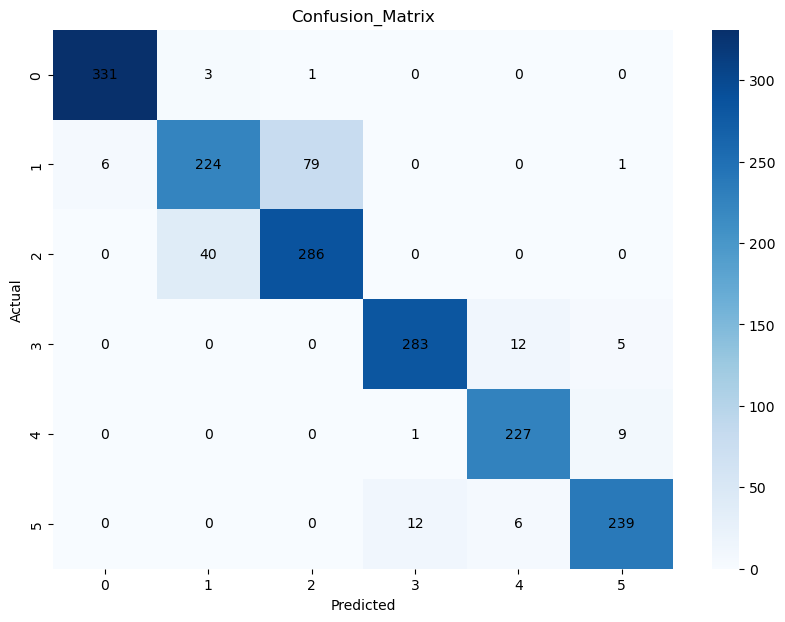

In [13]:
model = RandomForestClassifier(n_estimators=100)
model.fit(x_train,y_train)
print(f'정확도: {model.score(x_val,y_val)}')

y_pred = model.predict(x_val)


plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_val,y_pred),fmt='d',cmap='Blues',xticklabels=model.classes_, yticklabels=model.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion_Matrix')
for i in range(len(confusion_matrix(y_val,y_pred))):
    for j in range(len(confusion_matrix(y_val,y_pred)[i])):
        plt.text(j + 0.5, i + 0.5, f'{confusion_matrix(y_val,y_pred)[i][j]}', ha='center', va='center', color='black')
plt.show()
rfc_classification_report = classification_report(y_val,y_pred)

### (4) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

## model 구조

In [14]:
# model = Sequential([
#             Input((x_train.shape[-1],)),
#             Dense(16, activation='relu'),
#             Dense(32, activation='relu'),
#             Dense(64,activation='relu'),
#             Dense(6, activation='softmax')
#         ])
        
# # 모델 컴파일
# model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'],)

# checkpoint = ModelCheckpoint(
#     'best_model.keras',          # 저장할 파일명
#     monitor='val_accuracy',   # 모니터링할 지표
#     save_best_only=True,      # 가장 좋은 성능의 모델만 저장
#     mode='max',               # 최대값을 찾기 때문에 'max'
#     verbose=1                # 저장 시 메시지 출력
# )
#  # 모델 학습
# result = model.fit(x_train, y_train,shuffle=True,epochs=50,validation_split=.2,callbacks=[checkpoint]).history

In [15]:
# dl_acc_history_plot(result)

### (1) KFold

In [16]:
nfeature = x_train.shape[1]
y_train

array([1, 4, 5, ..., 5, 5, 5])

In [17]:
checkpoint = ModelCheckpoint(
    'best_model.keras',          # 저장할 파일명
    monitor='val_accuracy',   # 모니터링할 지표
    save_best_only=True,      # 가장 좋은 성능의 모델만 저장
    mode='max',               # 최대값을 찾기 때문에 'max'
    verbose=1                # 저장 시 메시지 출력
)

In [18]:
np.array(x_train).shape

(4116, 20)

In [19]:
y_train

array([1, 4, 5, ..., 5, 5, 5])

In [20]:
# 데이터 준비
x = np.array(x_train)  # 특성
y = np.array(y_train)  # 레이블

# KFold 설정
kf = KFold(n_splits=5, shuffle=True)

# 성능 기록을 위한 리스트
central_limit_theorem = []
val_accuracies = []

for train_index, val_index in kf.split(x):
    x_train_fold, x_val_fold = x[train_index], x[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # 모델 정의
    model = Sequential([
        Input((nfeature,)),
        Dense(256, activation='relu',kernel_regularizer=l1(0.01)),
        Dense(128, activation='relu',kernel_regularizer=l1(0.01)),
        Dense(64, activation='relu', kernel_regularizer=l1(0.01)),
        Dense(32, activation='relu', kernel_regularizer=l1(0.01)),
        Dense(6, activation='softmax')
        ])
        
    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    # 모델 학습
    result = model.fit(x_train_fold, y_train_fold, epochs=50, validation_data=(x_val_fold, y_val_fold),callbacks=[checkpoint],verbose=0)
        
    # 검증 정확도 기록
    val_accuracies.append(result.history['val_accuracy'][-1])
    central_limit_theorem.append(np.mean(val_accuracies))
    # 교차 검증 결과 출력
    print(f'Mean Validation Accuracy: {np.mean(val_accuracies)}')
    print(f'Standard Deviation of Validation Accuracy: {np.std(val_accuracies)}')
    print(f'central_limit_theorem: {central_limit_theorem}')



Epoch 1: val_accuracy improved from -inf to 0.79612, saving model to best_model.keras

Epoch 2: val_accuracy improved from 0.79612 to 0.82767, saving model to best_model.keras

Epoch 3: val_accuracy improved from 0.82767 to 0.84102, saving model to best_model.keras

Epoch 4: val_accuracy improved from 0.84102 to 0.85073, saving model to best_model.keras

Epoch 5: val_accuracy did not improve from 0.85073

Epoch 6: val_accuracy improved from 0.85073 to 0.85680, saving model to best_model.keras

Epoch 7: val_accuracy did not improve from 0.85680

Epoch 8: val_accuracy did not improve from 0.85680

Epoch 9: val_accuracy did not improve from 0.85680

Epoch 10: val_accuracy improved from 0.85680 to 0.86165, saving model to best_model.keras

Epoch 11: val_accuracy did not improve from 0.86165

Epoch 12: val_accuracy improved from 0.86165 to 0.86408, saving model to best_model.keras

Epoch 13: val_accuracy did not improve from 0.86408

Epoch 14: val_accuracy improved from 0.86408 to 0.86772,

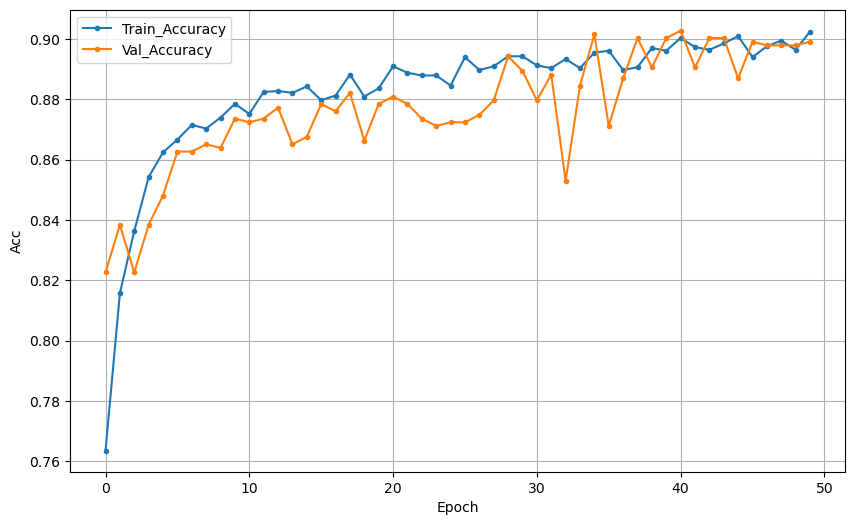

In [21]:
dl_acc_history_plot(result.history)

In [22]:
print(np.mean(central_limit_theorem))
print(np.std(central_limit_theorem))

0.8841256546974183
0.007242129008444555


## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

## PCA 데이터 파이프라인

In [23]:
def scaled_to_PCA(x_data:pd.DataFrame,n_components:int=12)->pd.DataFrame:
    # 정규화
    scaler = StandardScaler()
    x_columns = x_data.columns
    x = scaler.fit_transform(x_data)
    x = pd.DataFrame(x,columns=x_columns)
    
    # PCA Decomposition
    pca = PCA(n_components=n_components)
    principalComponents = pca.fit_transform(x)
    principalDF = pd.DataFrame(data=principalComponents,columns=['Comp']*n_components)
    return principalDF

In [24]:
test = pd.read_csv('../2024.10.16_미니프로젝트 3차_실습자료/data01_test.csv')
le = LabelEncoder()

x_test = test.drop(columns='Activity')
y_test = test['Activity']

y_test=le.fit_transform(y_test)

x_test = scaled_to_PCA(x_test,20)
y_pred = np.argmax(model.predict(x_test),1)

46/46 [==============================] - 0s 4ms/step


In [25]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       292
           1       0.69      0.68      0.69       254
           2       0.77      0.76      0.76       287
           3       0.84      0.87      0.86       228
           4       0.81      0.93      0.86       195
           5       0.87      0.78      0.82       215

    accuracy                           0.82      1471
   macro avg       0.82      0.83      0.82      1471
weighted avg       0.83      0.82      0.82      1471



# SMOTE 전처리

# 데이터 분리

In [26]:
data_test = pd.read_csv('../2024.10.16_미니프로젝트 3차_실습자료\data01_test.csv')
data_train = pd.read_csv('../2024.10.16_미니프로젝트 3차_실습자료\data01_train.csv')

x,y = data_train.drop(columns='Activity'),data_train['Activity']
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.2,random_state=1,stratify=y)

x_test = data_test.drop(columns='Activity')
y_test = data_test['Activity']

## SMOTE

In [27]:
checkpoint = ModelCheckpoint(
    'best_model_SMOTE.keras',          # 저장할 파일명
    monitor='val_accuracy',   # 모니터링할 지표
    save_best_only=True,      # 가장 좋은 성능의 모델만 저장
    mode='max',               # 최대값을 찾기 때문에 'max'
    verbose=1                # 저장 시 메시지 출력
)

In [28]:
from imblearn.over_sampling import SMOTE

In [179]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train

array([2, 2, 3, ..., 4, 4, 4])

In [180]:
ovsampler = SMOTE(random_state=1)
x_train_over,y_train_over = ovsampler.fit_resample(x_train,y_train)
x_train_over = scaled_to_PCA(x_train_over,20)


In [181]:
y_train_over

array([2, 2, 3, ..., 5, 5, 5])

In [182]:
# KFold 설정
kf = KFold(n_splits=5, shuffle=True)

x = np.array(x_train_over)  # 특성
y = np.array(y_train_over)  # 레이블

# 성능 기록을 위한 리스트
central_limit_theorem = []
val_accuracies = []

for train_index, val_index in kf.split(x):
    x_train_fold, x_val_fold = x[train_index], x[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # 모델 정의
    model = Sequential([
        Input((nfeature,)),
        Dense(256, activation='relu',kernel_regularizer=l1(0.01)),
        Dense(128, activation='relu',kernel_regularizer=l1(0.01)),
        Dense(64, activation='relu', kernel_regularizer=l1(0.01)),
        Dense(32, activation='relu', kernel_regularizer=l1(0.01)),
        Dense(6, activation='softmax')
        ])
        
    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    # 모델 학습
    result = model.fit(x_train_fold, y_train_fold, epochs=50, validation_data=(x_val_fold, y_val_fold),callbacks=[checkpoint],verbose=0)
        
    # 검증 정확도 기록
    val_accuracies.append(result.history['val_accuracy'][-1])
    central_limit_theorem.append(np.mean(val_accuracies))
    # 교차 검증 결과 출력
    print(f'Mean Validation Accuracy: {np.mean(val_accuracies)}')
    print(f'Standard Deviation of Validation Accuracy: {np.std(val_accuracies)}')
    print(f'central_limit_theorem: {central_limit_theorem}')



Epoch 1: val_accuracy improved from -inf to 0.82540, saving model to best_model_SMOTE.keras

Epoch 2: val_accuracy improved from 0.82540 to 0.87582, saving model to best_model_SMOTE.keras

Epoch 3: val_accuracy improved from 0.87582 to 0.88796, saving model to best_model_SMOTE.keras

Epoch 4: val_accuracy improved from 0.88796 to 0.89916, saving model to best_model_SMOTE.keras

Epoch 5: val_accuracy did not improve from 0.89916

Epoch 6: val_accuracy improved from 0.89916 to 0.91130, saving model to best_model_SMOTE.keras

Epoch 7: val_accuracy did not improve from 0.91130

Epoch 8: val_accuracy did not improve from 0.91130

Epoch 9: val_accuracy improved from 0.91130 to 0.91783, saving model to best_model_SMOTE.keras

Epoch 10: val_accuracy improved from 0.91783 to 0.92904, saving model to best_model_SMOTE.keras

Epoch 11: val_accuracy did not improve from 0.92904

Epoch 12: val_accuracy did not improve from 0.92904

Epoch 13: val_accuracy did not improve from 0.92904

Epoch 14: val_

In [186]:
np.mean(central_limit_theorem)

0.9079891043901445

In [185]:
test = pd.read_csv('../2024.10.16_미니프로젝트 3차_실습자료/data01_test.csv')
le = LabelEncoder()

x_test = test.drop(columns='Activity')
y_test = test['Activity']

y_test=le.fit_transform(y_test)

x_test = scaled_to_PCA(x_test,20)
y_pred = np.argmax(model.predict(x_test),1)

print(classification_report(y_test,y_pred))

46/46 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       292
           1       0.59      0.63      0.61       254
           2       0.70      0.64      0.67       287
           3       0.84      0.83      0.83       228
           4       0.83      0.87      0.85       195
           5       0.80      0.83      0.81       215

    accuracy                           0.79      1471
   macro avg       0.79      0.79      0.79      1471
weighted avg       0.79      0.79      0.79      1471



In [29]:
le.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)